# Tagesspiegel Data Challenge

## Einrichten des Notebooks


In [1]:
# Import der erforderlichen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime, timedelta
import chardet
from statistics import median


## Laden, Sichten und Bereinigen der Daten


In [3]:
 # CSV-Datei öffnen und Zeichenkodierungstyp erkennen
with open('daten/tagesspiegel_articles_data.csv', 'rb') as datei:
    daten = datei.read()
    zeichenkodierung = chardet.detect(daten)['encoding']

In [4]:
print(zeichenkodierung)


Windows-1252


In [5]:
# CSV-Datei als Pandas DataFrame öffnen
haupt_df = pd.read_csv('daten/tagesspiegel_articles_data.csv', delimiter= ';', encoding=zeichenkodierung)

In [6]:
# Ausgabe des DataFrames
haupt_df.head(5)

,Title,Published,Section,Tags,PaywallHits,SubscriberPageViews,PageViews,Conversions
0,Die Last mit Omikron: So infektiös sind Geimpfte,19.02.2022 13:00,Wissen,NaN,121682,3123,126028,30
1,Schwere Verläufe auch mit Omikron: Wer liegt j...,21.02.2022 07:00,Berlin,"charité,coronavirus,mitte",74583,2331,77869,24
2,Auffälliger Anstieg von Herzerkrankungen: Die ...,NaN,Wissen,NaN,54393,437,54927,3
3,BVG erwischt 4500 Handy-Schwarzfahrer : Zwei-M...,09.02.2022 21:06,Berlin,NaN,47709,2171,50429,27
4,Nicht bis 67 arbeiten: Wie Sie abschlagsfrei f...,07.02.2022 14:28,Wirtschaft,NaN,32056,1388,33863,21


In [7]:
# Einen Überblick über den DataFrame beschaffen und die Anzahl der Nullvalues prüfen
haupt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                1000 non-null   object
 1   Published            895 non-null    object
 2   Section              945 non-null    object
 3   Tags                 246 non-null    object
 4   PaywallHits          1000 non-null   int64 
 5   SubscriberPageViews  1000 non-null   int64 
 6   PageViews            1000 non-null   int64 
 7   Conversions          1000 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 62.6+ KB


In [8]:
# Spaltennamen in Kleinbuchstaben darstellen
haupt_df.columns = haupt_df.columns.str.lower()  

In [9]:
# Konvertieren der Spalte 'published' in den Datentyp datetime
haupt_df['published'] = pd.to_datetime(haupt_df['published'], dayfirst=True)


In [ ]:
# Entfernen der Spalte "Tags", da sich hier sehr viele Nullvalues befinden
haupt_df = haupt_df.drop('tags', axis=1)


In [14]:
# Die Anzahl der Duplikate prüfen, in diesem Fall nur für "Title" interessant  
haupt_df.nunique(axis=0)

title                  994
published              863
section                 19
paywallhits            634
subscriberpageviews    476
pageviews              715
conversions             27
dtype: int64

In [15]:
# Prüfen, ob es Artikel mehrmals in der Tabelle gibt
anzahl_duplikate = haupt_df.duplicated(subset='title').sum()
anzahl_duplikate


6

In [16]:
# Hiermit werden alle doppelten Werte der Spalte 'Title' angezeigt
duplikate = haupt_df.duplicated(subset='title', keep=False)
duplikate_df = haupt_df[duplikate]
duplikate_df


,title,published,section,paywallhits,subscriberpageviews,pageviews,conversions
26,Wie lange hält der Booster?: „Wer die dritte I...,NaT,Gesundheit,11388,1757,13779,12
66,Ungleiche Verteilung von Care-Arbeit: Weg vom ...,2022-02-12 10:30:00,Gesellschaft / Familie,5690,370,6184,0
357,"Toxische Beziehungen: So erkennen Sie sie, so ...",2021-10-04 10:48:00,Gesellschaft,780,18,803,8
529,Berliner Uhrenwerkstatt: Hier tickt noch die G...,2022-02-09 13:52:00,Berlin,194,155,379,2
532,Der brennt fürs Essen: Tobias Beck kocht spekt...,2022-02-17 15:25:00,NaN,174,157,375,0
570,"Toxische Beziehungen: So erkennen Sie sie, so ...",2021-10-04 10:48:00,NaN,293,20,321,0
717,Der brennt fürs Essen: Tobias Beck kocht spekt...,2022-02-17 15:25:00,Gesellschaft,92,68,184,2
765,Ungleiche Verteilung von Care-Arbeit: Weg vom ...,2022-02-10 21:30:00,NaN,92,45,147,0
804,Berliner Uhrenwerkstatt: Hier tickt noch die G...,2022-02-07 00:00:00,Berlin / Bezirke,74,43,127,0
828,Fastfood vom Fahrdienst: Uber Eats liefert in ...,2022-02-01 10:00:00,NaN,78,28,116,0


In [17]:
# Es werden die Zahlen in den Duplikaten summiert und die Dublikate zusammengefügt

haupt_df = haupt_df.groupby('title').agg({'published': 'first', 
                                     'section': 'first', 
                                     'paywallhits': 'sum', 
                                     'subscriberpageviews': 'sum',
                                     'pageviews' : 'sum',
                                     'conversions' : 'sum'}).reset_index()



In [361]:
# Überprüfen was passiert, wenn der erste Wert des Dubplikats NaN war. Ergbniss: dann wird der zweite Werte beibehalten
haupt_df[haupt_df['title'].str.contains('Der brennt fürs Essen')]


,title,published,section,paywallhits,subscriberpageviews,pageviews,conversions
195,Der brennt fürs Essen: Tobias Beck kocht spekt...,2022-02-17 15:25:00,Gesellschaft,266,225,559,2


In [366]:
# Erste statistische Auswertung
haupt_df.describe()

,paywallhits,subscriberpageviews,pageviews,conversions
count,994.000000,994.000000,994.000000,994.000000
mean,1503.575453,299.587525,1942.298793,2.434608
std,5860.567166,483.199694,6298.322162,6.421597
min,0.000000,0.000000,56.000000,0.000000
25%,86.250000,45.000000,163.000000,0.000000
50%,223.500000,129.000000,435.500000,0.000000
75%,924.000000,351.750000,1490.500000,2.000000
max,121682.000000,5777.000000,126028.000000,71.000000


*Ergebnis: Die verschiedenen Kennzahlen auf einzelne Artikel, nicht auf Ressorts bezogen, verzeichnen nach oben hin große Outliner*

In [18]:
# Betrachtung der Zahlen durch Sotierung nach einzelnen Kennzahlen, aufsteigend und absteigend, Spalte wird ausgetauscht
sortierter_df = haupt_df.sort_values(by='subscriberpageviews', ascending=False)
sortierter_df.head(10)


,title,published,section,paywallhits,subscriberpageviews,pageviews,conversions
61,Auch Geboosterte sollten aufpassen: Wo die Gef...,2022-02-02 15:54:00,Wissen,14511,5777,22681,18
845,"Unsinn“, „Rohrkrepierer“, „sauteuer“: Bettina ...",2022-02-04 21:08:00,Berlin,14107,4524,20327,21
16,83 Männer in 17 Jahren: Was Mia auf ihre Sexli...,2022-02-12 08:00:00,Gesellschaft,13371,3185,17827,65
221,Die Last mit Omikron: So infektiös sind Geimpfte,2022-02-19 13:00:00,Wissen,121682,3123,126028,30
7,24 Stunden Omikron in Berlin: Szenen einer Sta...,2022-01-30 09:00:00,Gesellschaft,18044,3103,22380,23
48,Anschluss nur für Privatversicherte: „Jeder Ka...,2022-02-06 15:34:00,Gesellschaft,6391,2865,10282,12
683,Putins Propaganda bröckelt: Kippt jetzt die St...,2022-02-27 17:15:00,Gesellschaft,10164,2755,14371,26
21,Abkehr vom Altkanzler: War Schröder nur ein Te...,2022-02-23 17:41:00,Politik,20319,2734,24253,15
324,Ex-Politiker bei russischen Unternehmen: Warum...,2022-02-25 18:55:00,Politik,11178,2469,14675,14
648,Osteuropa-Historiker Karl Schlögel: „Putin wil...,2022-02-27 13:32:00,Politik,8209,2457,11785,27


In [19]:
# Überprüfen der Anzahl freier Artikel. Ergebniss: Anzahl gering 
anzahl_freierartikel = (haupt_df['paywallhits'] == 0).sum()
print(anzahl_freierartikel)

27


### Festzustellen ist, dass die Anzahl der Artikel mit zugeordnetem Unterressort/Ruprik sehr gering ist, deswegen werden im Folgenden die Unterressorts den Hauptressorts zugeordnet

In [20]:
# Datatype der Spalte "Section" prüfen
print(haupt_df['section'].dtype)

object


In [21]:
# Das Format der Spalte "Section" in einen Sting umwandeln
haupt_df['section'] = haupt_df['section'].astype(str)


In [22]:
# In jeder Zeile die Unterruprik löschen, falls vorhanden
haupt_df['section'] = haupt_df['section'].apply(lambda x: x.split()[0])


In [23]:
# Spalte "Anzahl" hinzufügen, um zu prüfen, wieviele Artikel pro Ressort in der Tabelle sind 
haupt_df['anzahl'] = haupt_df['section'].map(haupt_df['section'].value_counts())
haupt_df.head(5)

,title,published,section,paywallhits,subscriberpageviews,pageviews,conversions,anzahl
0,1.008.405 Euro statt 599.000 Euro: Wie teuer e...,2022-01-20 11:45:00,Wirtschaft,69,63,137,2,89
1,100 Gesichter einer Berliner Straße: Arme und ...,2022-02-06 13:33:00,Berlin,253,239,590,5,393
2,100 Jahre Albert Einstein in Berlin-Spandau: D...,2022-01-19 12:28:00,Berlin,134,29,168,2,393
3,"1000 kaputte Bäume, 13 beschädigte Schulen: Di...",NaT,Berlin,99,66,172,2,393
4,110-Prozent-Finanzierung: Wie Sie eine Immobil...,2021-05-13 09:19:00,Wirtschaft,86,68,162,0,89


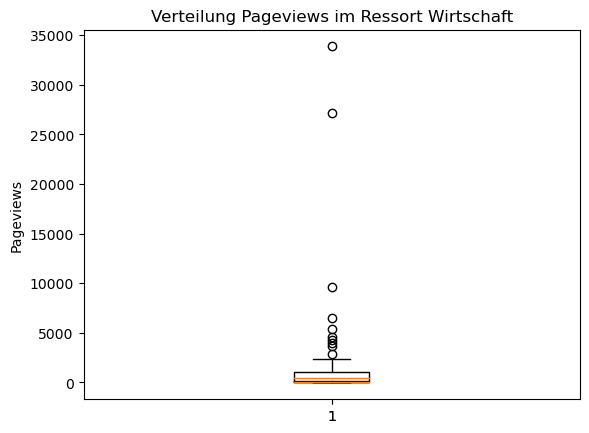

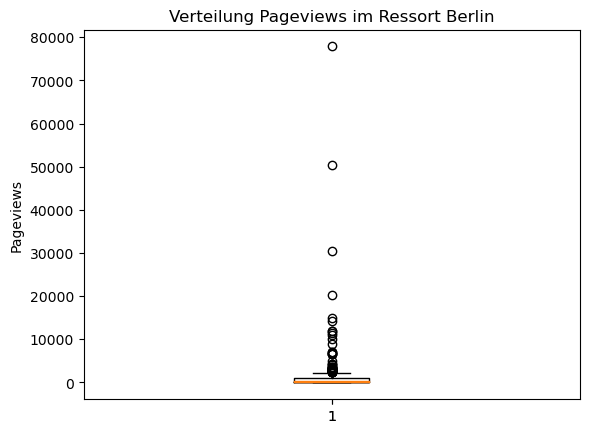

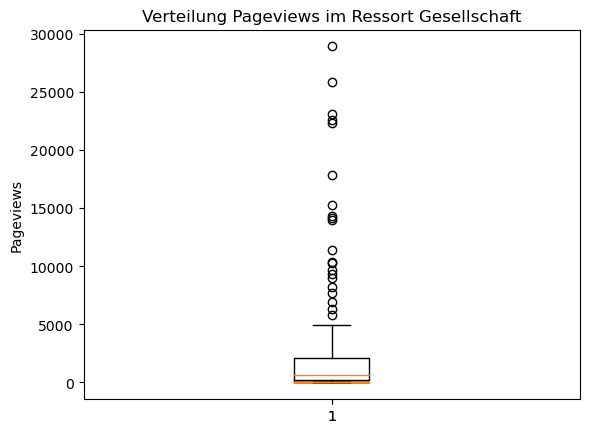

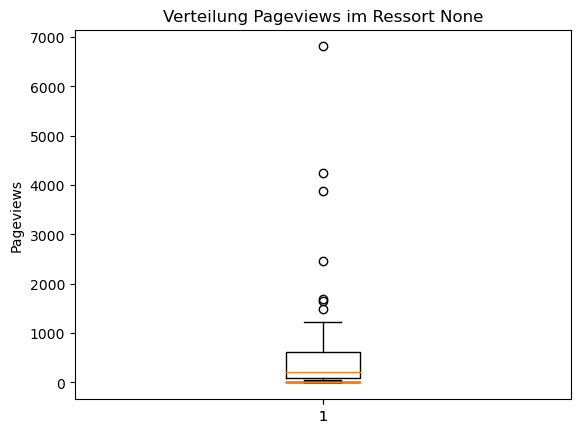

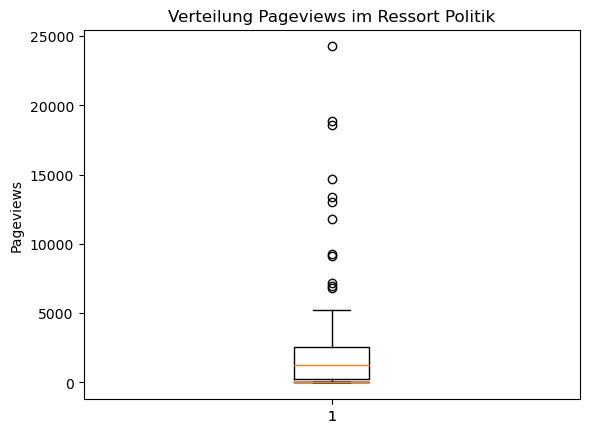

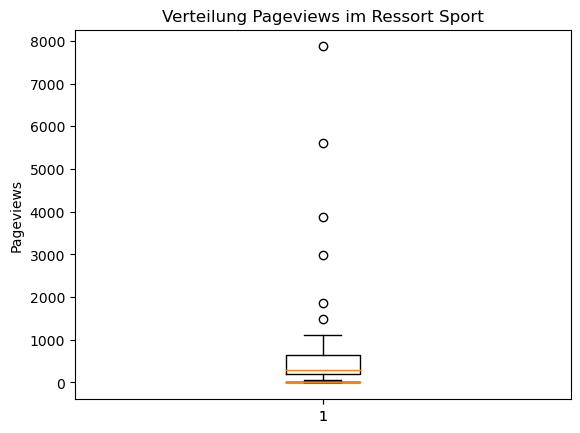

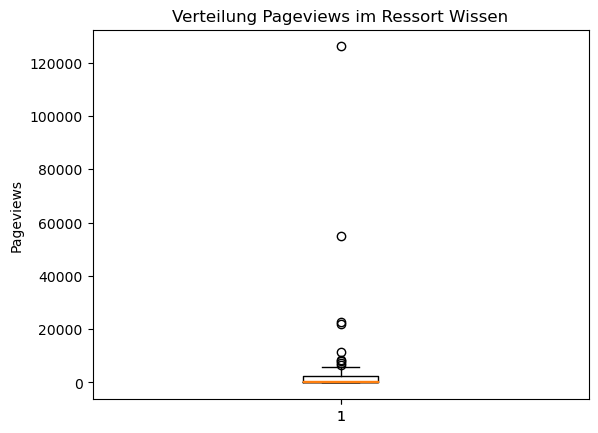

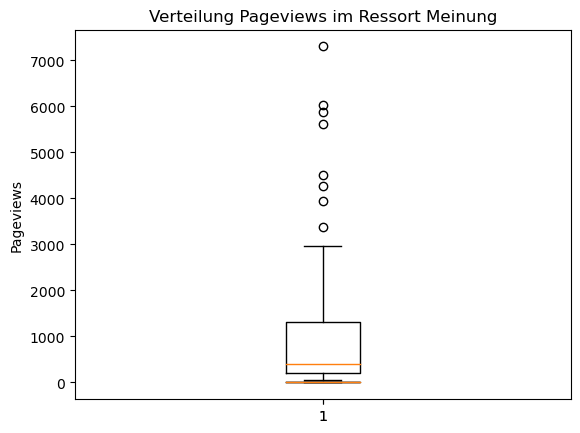

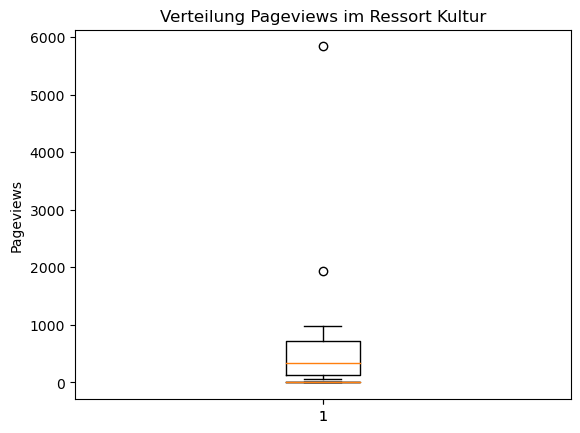

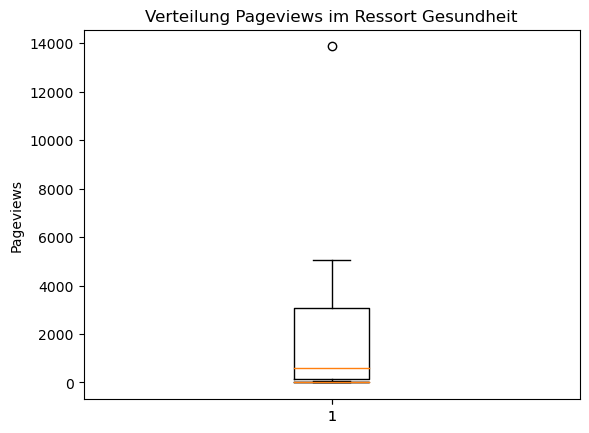

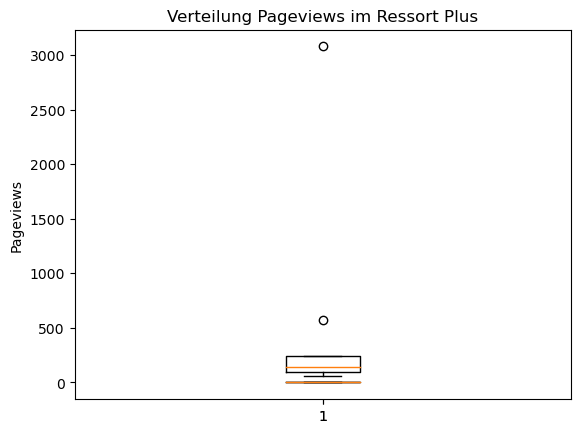

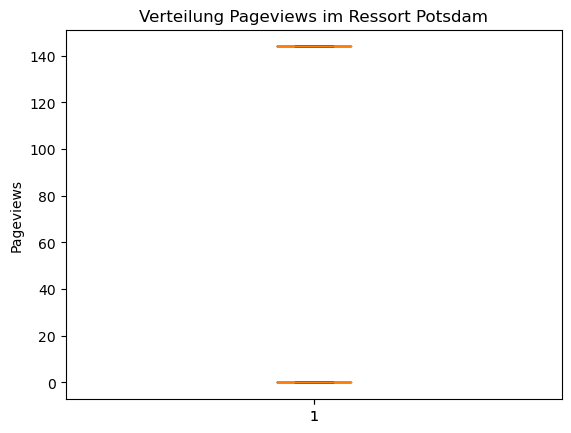

In [381]:
# Durch die Funktion .describe konnte festgestellt werden, dass die Kennzahlen für die Summe der Artikel große Outliner verzeichnen. 
# Nun wird ein BoxPlot für jede Section für die Spalte 'Pageview' erstellen um die Outliner in den unterschiedlichen Ressorts zu prüfen. 
unique_sections = haupt_df['section'].unique()
for i in unique_sections:
    section_df = haupt_df[haupt_df['section'] == i]
    x = section_df['pageviews']
    
    plt.boxplot(x)
    plt.boxplot(y)

    plt.ylabel('Pageviews')


    plt.title(f'Verteilung Pageviews im Ressort {i}')
    plt.show()

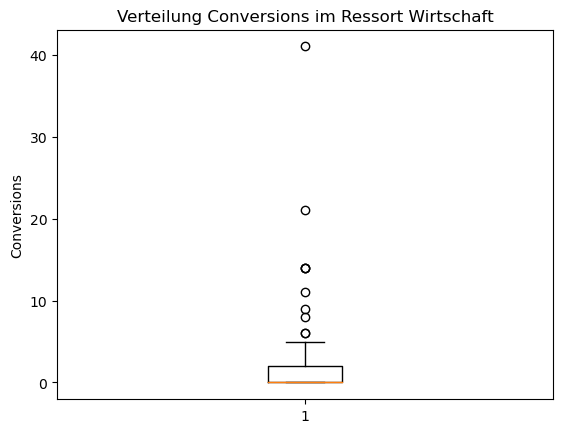

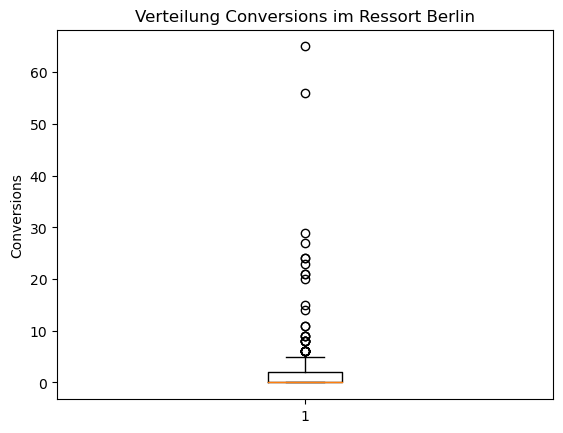

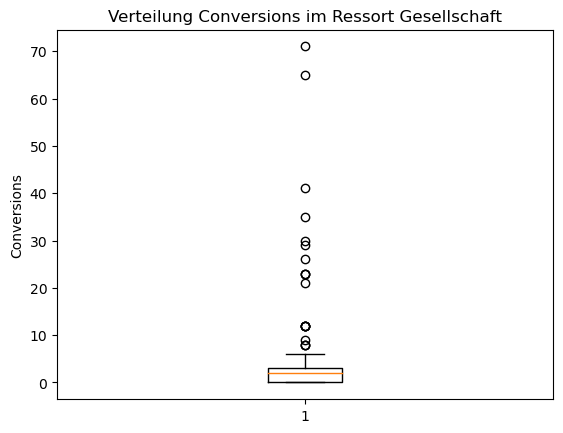

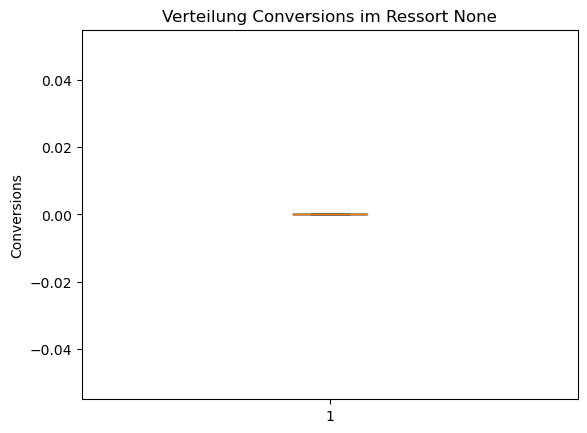

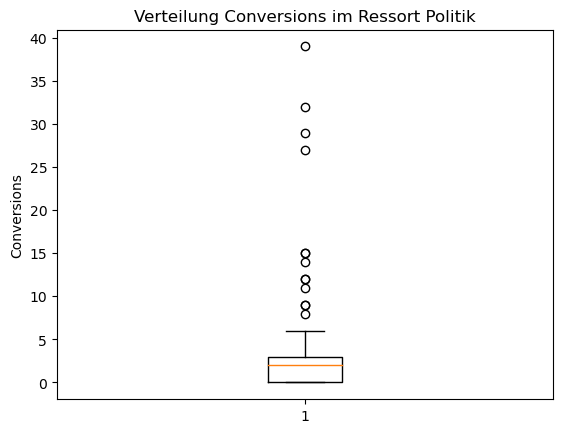

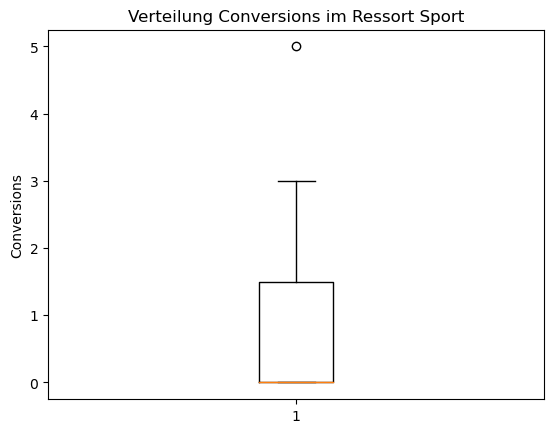

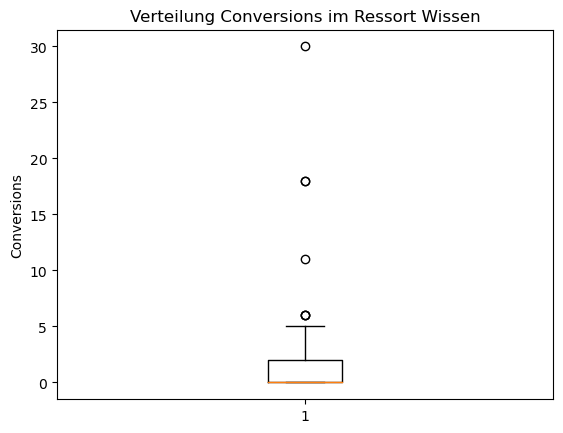

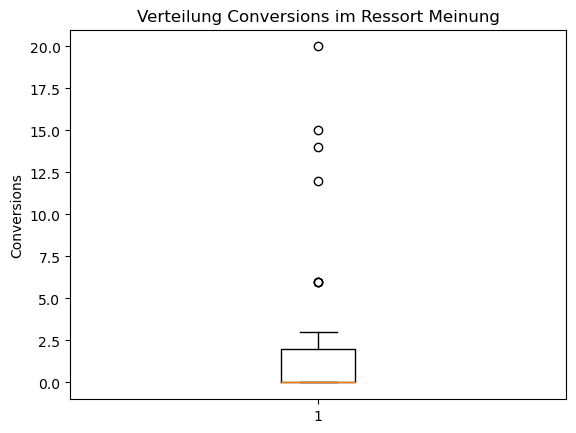

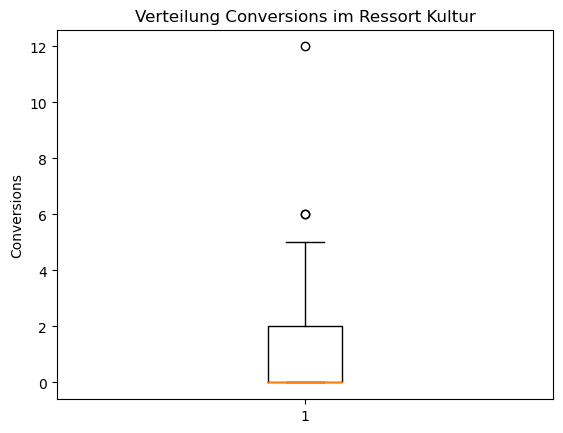

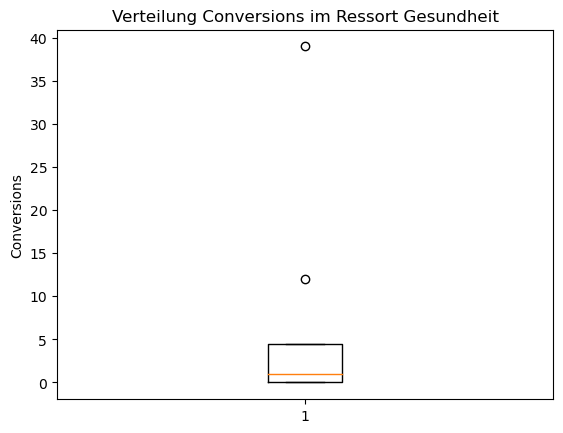

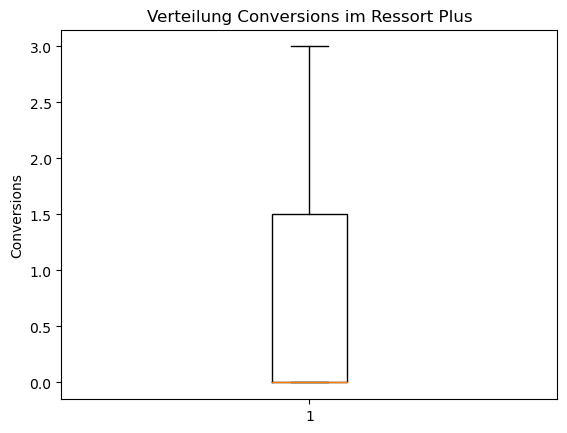

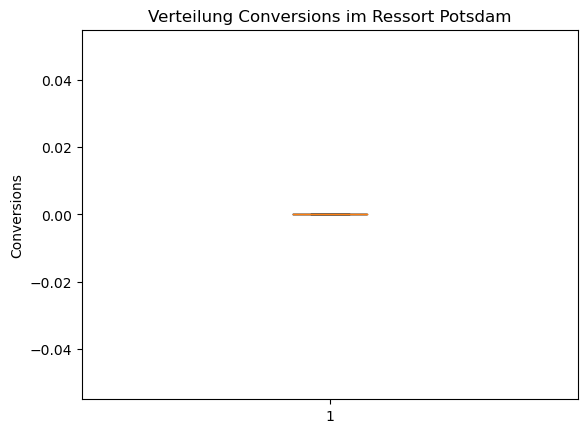

In [25]:
# Ein BoxPlot für jede Section für die Spalte 'Conversion' erstellen 
unique_sections = haupt_df['section'].unique()
for i in unique_sections:
    section_df = haupt_df[haupt_df['section'] == i]
    x = section_df['conversions']
    
    plt.boxplot(x)

    plt.ylabel('Conversions')


    plt.title(f'Verteilung Conversions im Ressort {i}')
    plt.show()

Ergebniss: Die Ressorts verzeichnen zum Teil große extreme Outliners, welche den Schnitt verzerren. Lösung: den Median berechnen.

In [26]:
# Berechnen des Median für jede Kennzahl 
median_werte = haupt_df.groupby('section')[['conversions', 'pageviews', 'subscriberpageviews', 'paywallhits']].median()
median_werte_sortiert = median_werte.sort_values(by='conversions', ascending=False)
median_werte_sortiert.head(10)


,conversions,pageviews,subscriberpageviews,paywallhits
section,,,,
Gesellschaft,2.0,652.0,224.0,317.0
Politik,2.0,1233.5,255.0,796.0
Gesundheit,1.0,613.0,53.5,565.5
Berlin,0.0,382.0,111.0,186.0
Kultur,0.0,341.0,88.0,173.0
Meinung,0.0,397.5,146.0,148.0
None,0.0,204.0,59.0,104.0
Plus,0.0,146.0,33.5,102.5
Potsdam,0.0,144.0,41.0,93.0


Ergebnis: Berachtet man den Median der vier Kennzahlen, dann ist Politik das Ressort mit den beste Werten bei allen Kennzahlen, gefolgt von Gesellschaft und Gesundheit.
Im folgenden betrachten wir den Durchschnitt aller Werte:

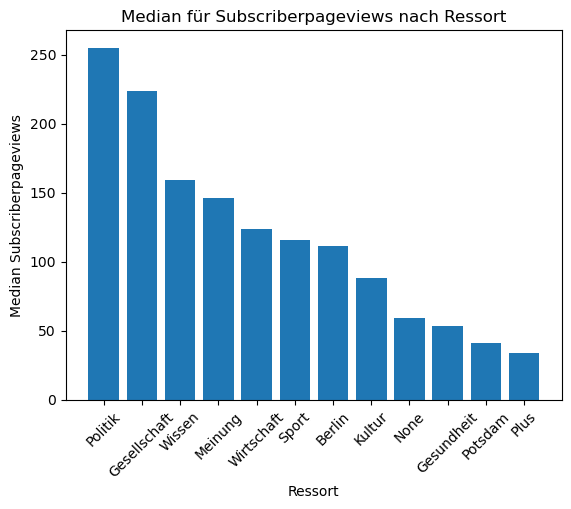

In [31]:
# Erstellen eines Balkendiagramms für den einfacheren Vergleich des Medians der Kennzahl "Subscriberpageview"
unique_sections = haupt_df['section'].unique()
median_subscriberpageviews = []

for section in unique_sections:
    section_df = haupt_df[haupt_df['section'] == section]
    median_subscriberpageview = section_df['subscriberpageviews'].median()
    median_subscriberpageviews.append(median_subscriberpageview)

# DataFrame mit Sektionen und Durchschnittswerten erstellen
data = pd.DataFrame({'Section': unique_sections, 'Median Subscriberpageviews': median_subscriberpageviews})

# DataFrame nach Durchschnittswerten absteigend sortieren
sorted_data = data.sort_values(by='Median Subscriberpageviews', ascending=False)

x = np.arange(len(unique_sections))

plt.bar(x, sorted_data['Median Subscriberpageviews'])
plt.xticks(x, sorted_data['Section'], rotation=45)
plt.xlabel('Ressort')
plt.ylabel('Median Subscriberpageviews')
plt.title('Median für Subscriberpageviews nach Ressort')

plt.show()


In [35]:
# Ausrechnen des Durchschnitts zum Vergleich 
mean_werte = haupt_df.groupby(['section', 'anzahl'])[['conversions', 'pageviews', 'subscriberpageviews', 'paywallhits']].mean().reset_index()
mean_werte_sortiert = mean_werte.sort_values(by='conversions', ascending=False)
mean_werte_sortiert


,section,anzahl,conversions,pageviews,subscriberpageviews,paywallhits
2,Gesundheit,8,6.875000,2867.125000,383.250000,2344.250000
1,Gesellschaft,159,4.276730,2619.842767,440.779874,1999.886792
7,Politik,94,3.617021,2752.606383,461.361702,2094.404255
10,Wirtschaft,89,2.359551,1656.314607,237.584270,1184.483146
4,Meinung,46,2.217391,1354.239130,372.239130,787.065217
11,Wissen,66,2.212121,5020.348485,401.772727,4292.484848
0,Berlin,393,2.022901,1514.572519,237.585242,1202.572519
3,Kultur,43,1.441860,542.441860,150.325581,346.767442
6,Plus,10,0.700000,476.700000,142.100000,280.100000
9,Sport,34,0.676471,964.676471,182.941176,724.147059


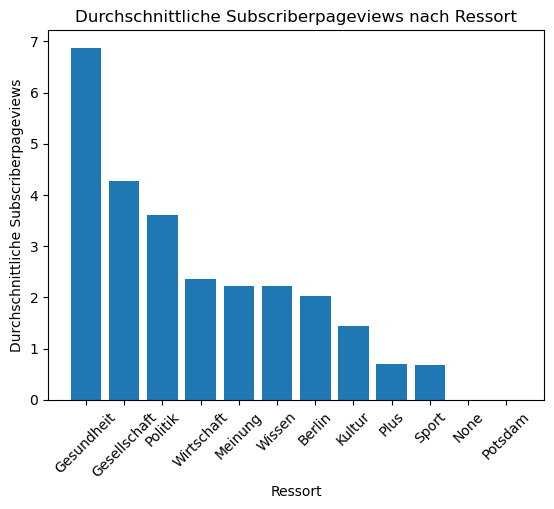

In [38]:
unique_sections = haupt_df['section'].unique()
average_subscriberpageviews = []

for section in unique_sections:
    section_df = haupt_df[haupt_df['section'] == section]
    average_subscriberpageview = section_df['conversions'].mean()
    average_subscriberpageviews.append(average_subscriberpageview)

# DataFrame mit Sektionen und Durchschnittswerten erstellen
data = pd.DataFrame({'Section': unique_sections, 'Average Subscriberpageviews': average_subscriberpageviews})

# DataFrame nach Durchschnittswerten absteigend sortieren
sorted_data = data.sort_values(by='Average Subscriberpageviews', ascending=False)

x = np.arange(len(unique_sections))

plt.bar(x, sorted_data['Average Subscriberpageviews'])
plt.xticks(x, sorted_data['Section'], rotation=45)
plt.xlabel('Ressort')
plt.ylabel('Durchschnittliche Subscriberpageviews')
plt.title('Durchschnittliche Subscriberpageviews nach Ressort')

plt.show()


Ergenis: Im Durchschnitt hat das Ressort Gesundheits den besten Wert bei Subscriberpageviews und anderen Kennzahlen.
Im folgenden betrachten wir die summierten Kennzahlen: 

In [39]:
#Nach Ressort gruppieren und die Summe der einzelenen Werte errechnen 
section_df = haupt_df.groupby(['section', 'anzahl'])[['conversions', 'pageviews', 'subscriberpageviews', 'paywallhits']].sum().reset_index()
section_df = section_df.sort_values(by='conversions', ascending=False)


In [40]:
section_df.head(22)

,section,anzahl,conversions,pageviews,subscriberpageviews,paywallhits
0,Berlin,393,795,595227,93371,472611
1,Gesellschaft,159,680,416555,70084,317982
7,Politik,94,340,258745,43368,196874
10,Wirtschaft,89,210,147412,21145,105419
11,Wissen,66,146,331343,26517,283304
4,Meinung,46,102,62295,17123,36205
3,Kultur,43,62,23325,6464,14911
2,Gesundheit,8,55,22937,3066,18754
9,Sport,34,23,32799,6220,24621
6,Plus,10,7,4767,1421,2801


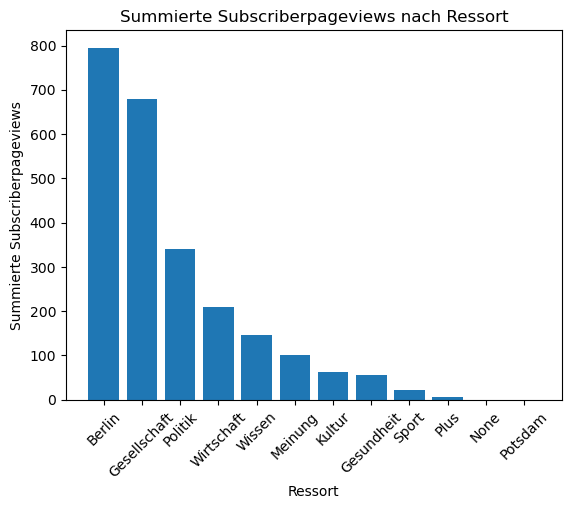

In [41]:
unique_sections = haupt_df['section'].unique()
sum_subscriberpageviews = []

for section in unique_sections:
    section_df = haupt_df[haupt_df['section'] == section]
    sum_subscriberpageview = section_df['conversions'].sum()
    sum_subscriberpageviews.append(sum_subscriberpageview)

# DataFrame mit Sektionen und Durchschnittswerten erstellen
data = pd.DataFrame({'Section': unique_sections, 'Sum Subscriberpageviews': sum_subscriberpageviews})

# DataFrame nach Durchschnittswerten absteigend sortieren
sorted_data = data.sort_values(by='Sum Subscriberpageviews', ascending=False)

x = np.arange(len(unique_sections))

plt.bar(x, sorted_data['Sum Subscriberpageviews'])
plt.xticks(x, sorted_data['Section'], rotation=45)
plt.xlabel('Ressort')
plt.ylabel('Summierte Subscriberpageviews')
plt.title('Summierte Subscriberpageviews nach Ressort')

plt.show()

Wenn wir die absoluten Zahlen betrachten, verzeichnet das Ressort "Berlin" die besten Zahlen, was nicht verwundert, da es die meisten Artikel verzeichnet, gefolgt von "Gesellschaft" mit den zweitmeisten Artikeln 

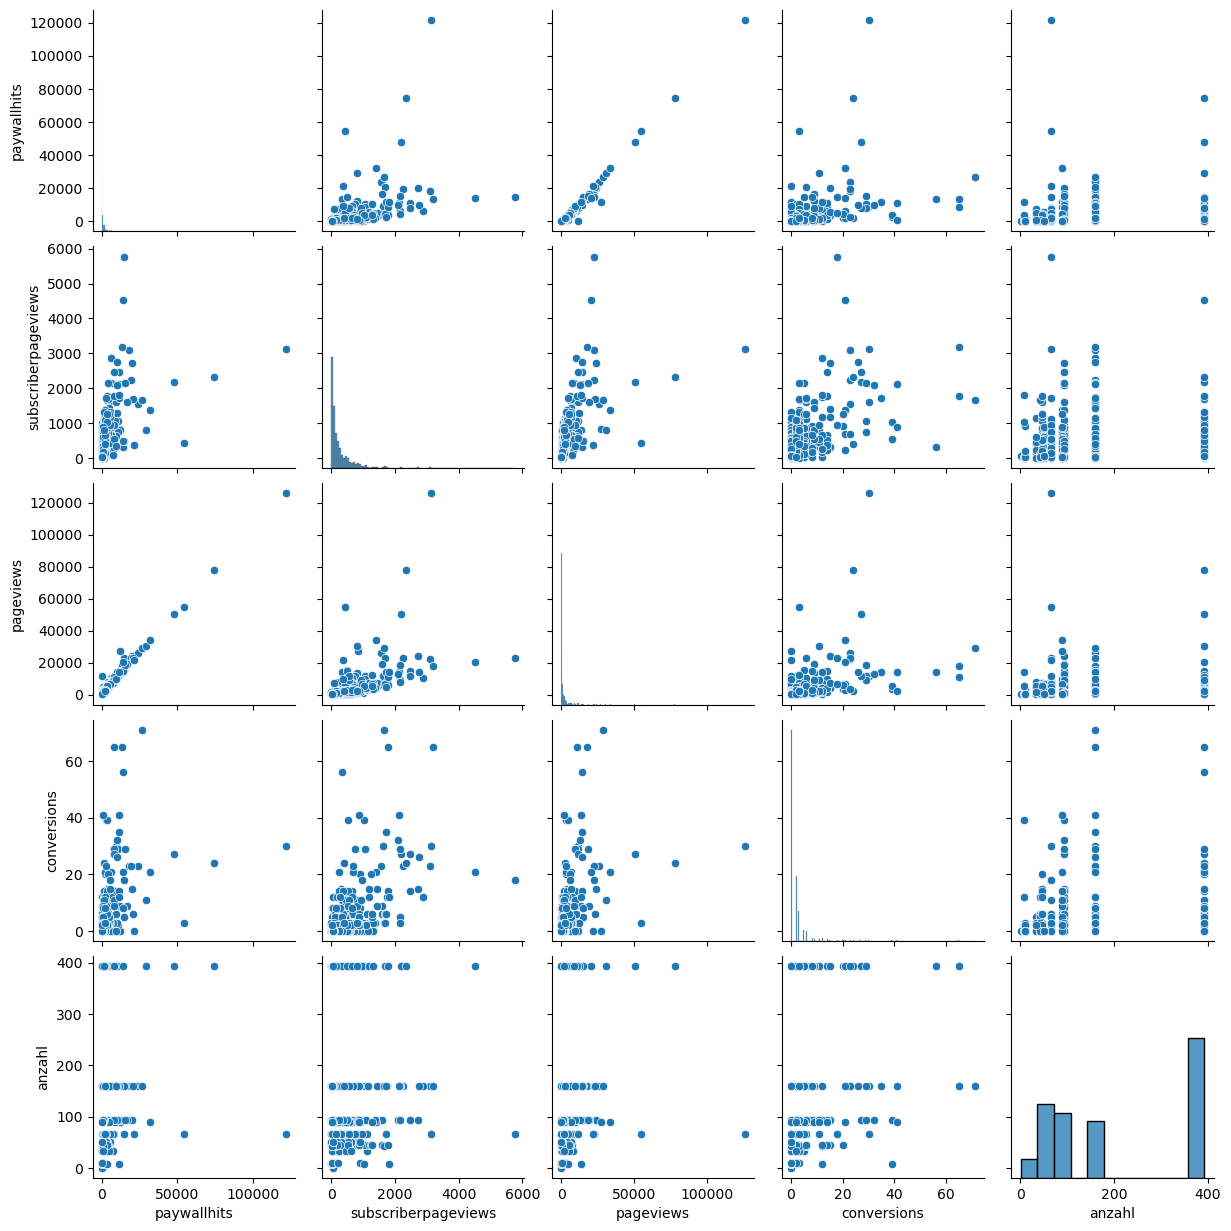

In [42]:
# Nach Signifikation Korrelationen. Ergbnis: Keine Überraschende bzw. relevante Korrelation auszumachen. 
# Interessant ist dass keine Korrelation zwischen Conversions und Pageviews vorhanden ist. 
sns.pairplot(haupt_df)

In [378]:
haupt_df.to_csv('haupt_data.csv', index=False)
